The code from plot_generation.ipynb will be the foundation for most of this.

The main change I wanted to make was that the information for the Manhattan plot should be source from the GWAS sumstats file, and not the assoc.dat file.
In addition, we are interested in looking at all the chromosomes at one time for the Manahattan plot.
Since we already have that data we can make that change now.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
def manhattan(pop, p_threshold=5e-8, subsample_rate=0.01):
    # Read the GWAS summary statistics file
    file_path = f'../data/raw/gwas/HF_Bothsex_{pop}_inv_var_meta_GBMI_052021_nbbkgt1.txt.gz'
    df = pd.read_csv(file_path, compression='gzip', sep='\t', header=0)

    # Ensure required columns exist
    required_cols = {'#CHR', 'POS', 'inv_var_meta_p'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing required columns in input file: {required_cols - set(df.columns)}")

    # Rename columns for consistency
    df = df.rename(columns={'#CHR': 'CHR', 'inv_var_meta_p': 'P'})

    # Select relevant columns and drop missing values
    df = df[['CHR', 'POS', 'P']].dropna()
    
    # Convert P-values to -log10(P) for plotting
    df['P'] = pd.to_numeric(df['P'], errors='coerce')
    df = df.dropna()  # Drop any remaining NaNs
    df['-log10(P)'] = df['P'].apply(lambda x: -np.log10(x))

    # Convert chromosome numbers to integers for sorting
    df['CHR'] = df['CHR'].astype(int)

    # Apply filtering:
    df_significant = df[df['P'] <= p_threshold]  # Keep all SNPs below threshold
    df_nonsignificant = df[df['P'] > p_threshold].sample(frac=subsample_rate, random_state=42)  # Subsample 1% of non-significant SNPs

    # Combine both datasets
    df = pd.concat([df_significant, df_nonsignificant])

    # Sort by chromosome and position
    df = df.sort_values(by=['CHR', 'POS'])

    # Generate a Manhattan plot
    plt.figure(figsize=(20, 6))
    colors = ['blue', 'red']  # Alternating colors for chromosomes

    # Create chromosome index mapping
    df['Chrom_Position'] = df.groupby('CHR')['POS'].transform(lambda x: x - x.min())

    # Set up x-axis positions
    chrom_max = df.groupby('CHR')['Chrom_Position'].max()
    chrom_offsets = chrom_max.cumsum().shift(fill_value=0)
    df['Adjusted_POS'] = df['Chrom_Position'] + df['CHR'].map(chrom_offsets)

    # Plot each chromosome separately
    for i, chrom in enumerate(df['CHR'].unique()):
        chr_data = df[df['CHR'] == chrom]
        plt.scatter(chr_data['Adjusted_POS'], chr_data['-log10(P)'], 
                    color=colors[i % 2], s=5)

    # Add significance threshold line
    #plt.axhline(y=-np.log10(p_threshold), color='black', linestyle='dashed', linewidth=1)

    # Format x-axis to show chromosome numbers
    tick_positions = chrom_offsets + chrom_max / 2
    plt.xticks(tick_positions, [str(chrom) for chrom in chrom_offsets.index])

    # Labels and title
    plt.xlabel("Chromosome")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Manhattan Plot of GWAS Data (Population: {pop})")

    plt.show()

    plt.savefig(f'../plots/manhattan/{pop}_manhattan.png')

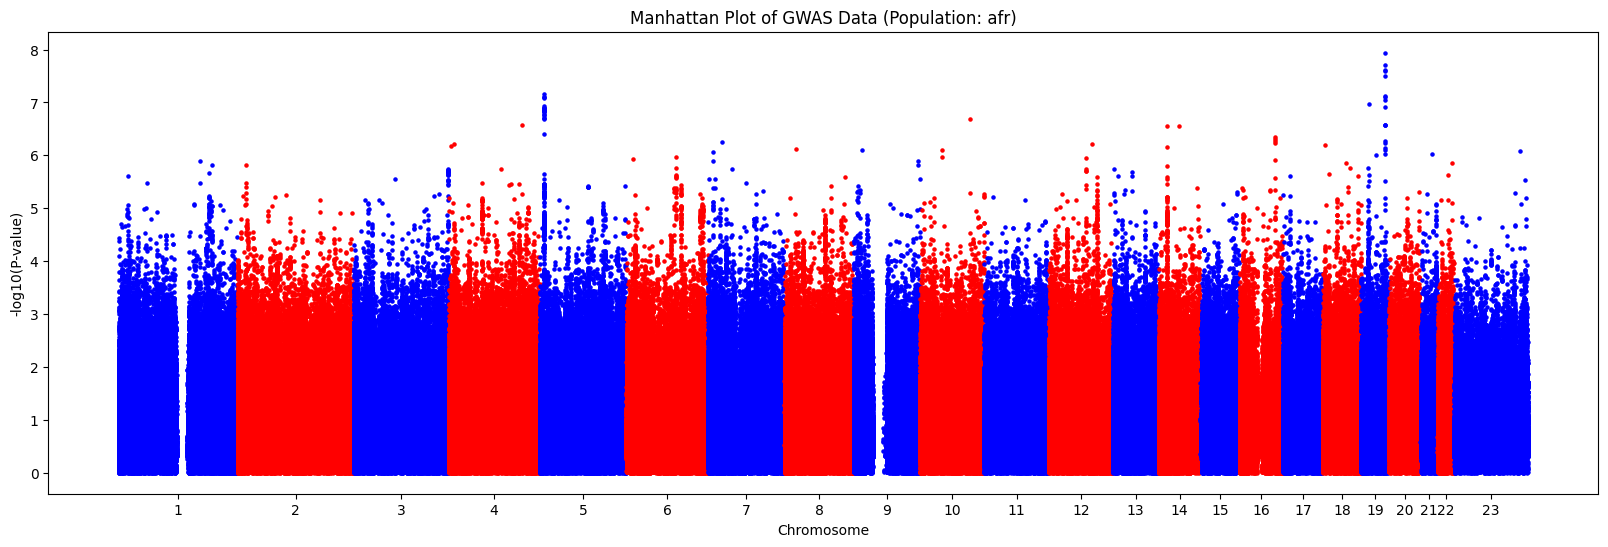

<Figure size 640x480 with 0 Axes>

In [7]:
manhattan('afr',  p_threshold=5e-1)

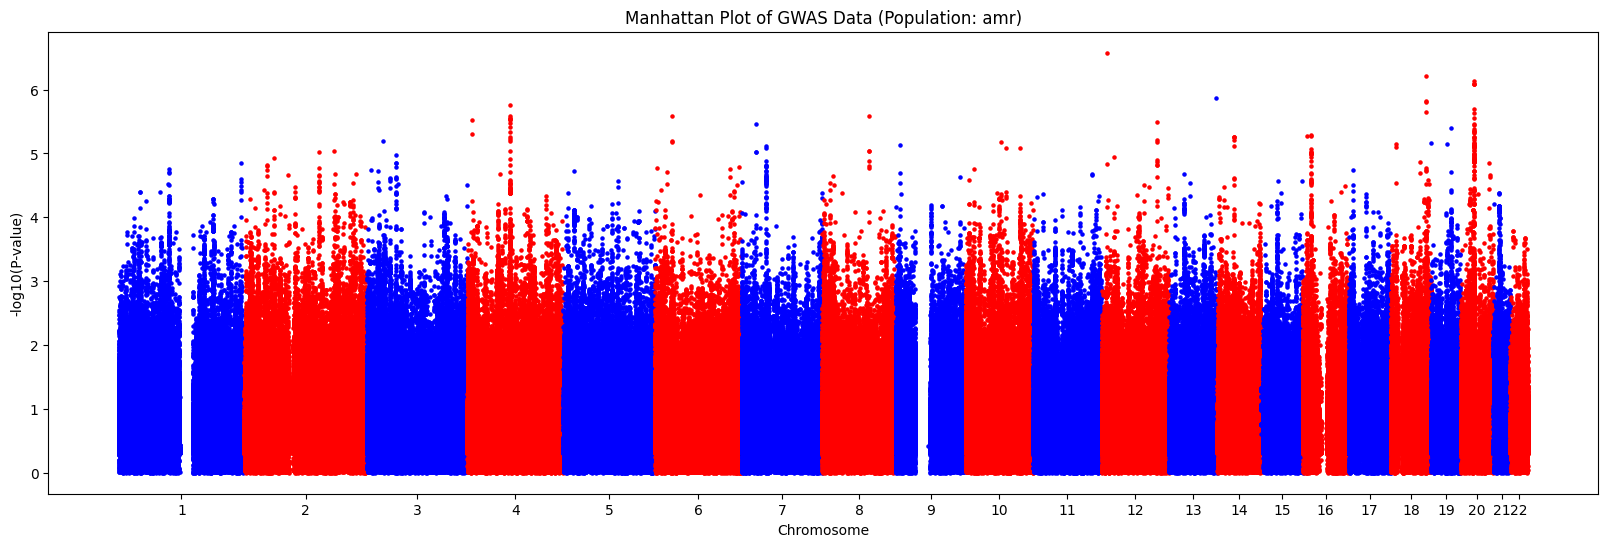

<Figure size 640x480 with 0 Axes>

In [8]:
manhattan('amr',  p_threshold=5e-1)

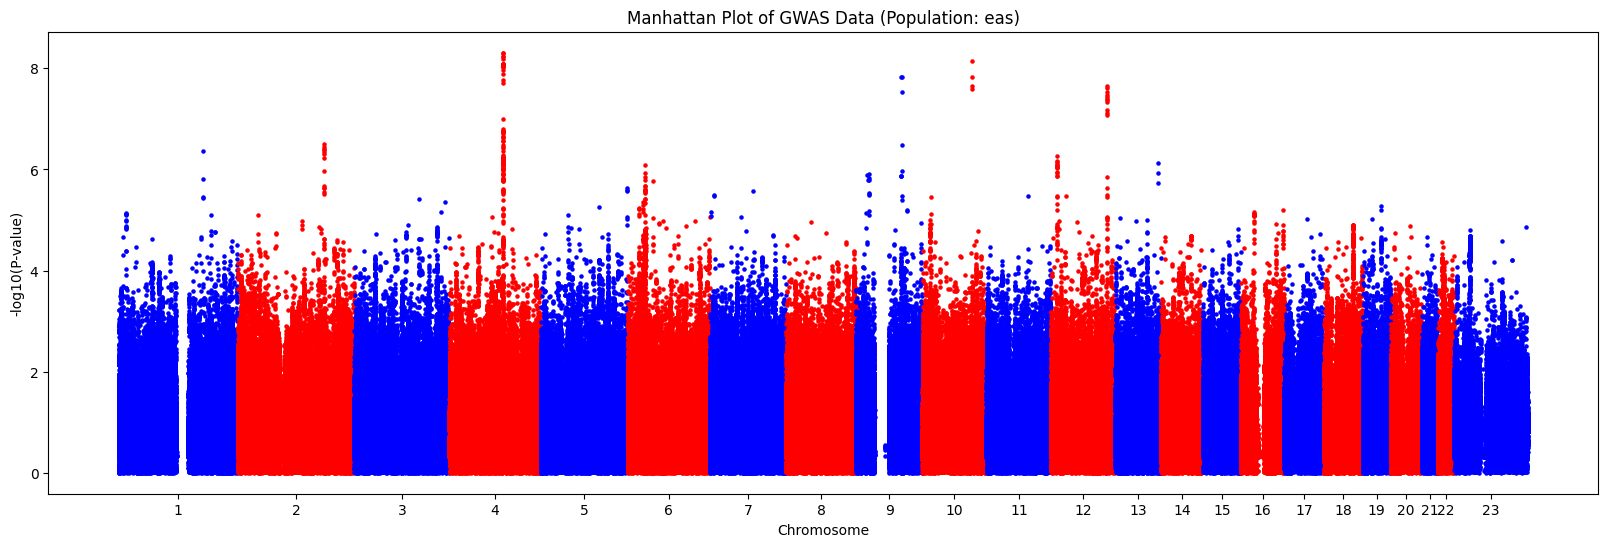

<Figure size 640x480 with 0 Axes>

In [9]:
manhattan('eas',  p_threshold=5e-1)

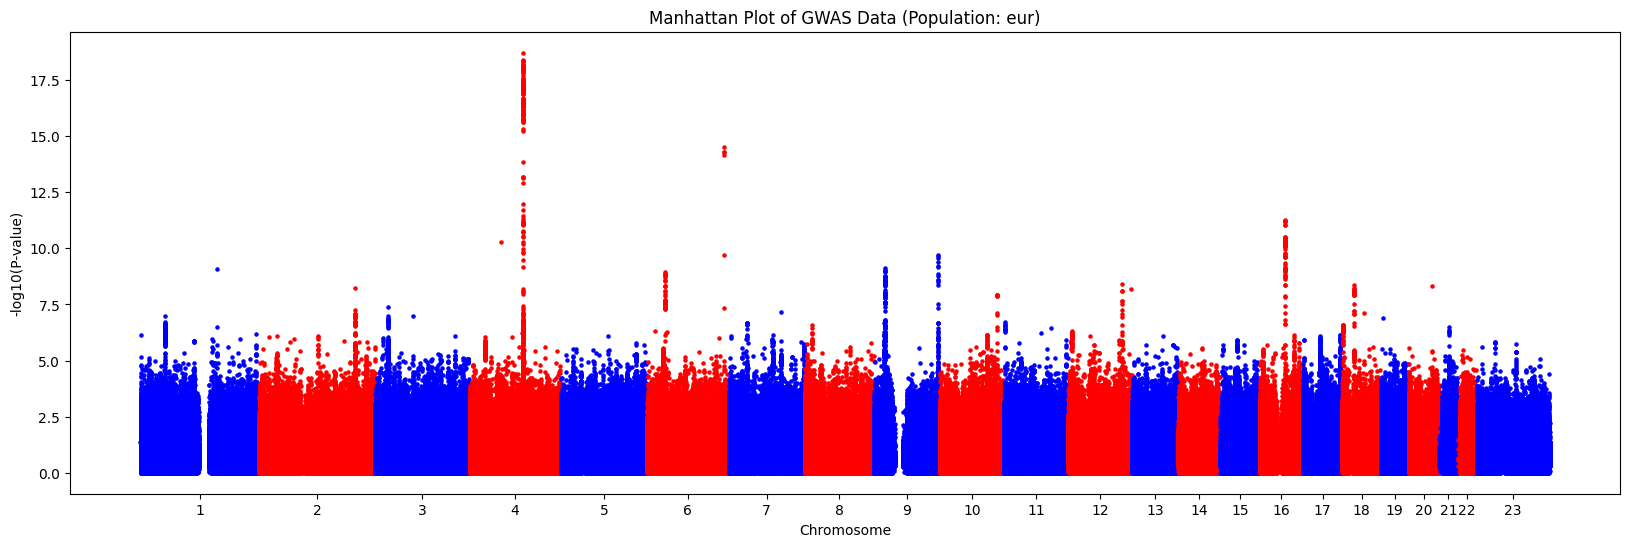

<Figure size 640x480 with 0 Axes>

In [10]:
manhattan('eur',  p_threshold=5e-1)

In [ ]:
def data_prep(chrom_num, pop):
    # Read the GWAS summary statistics file

    file_path = f'../data/assoc/{chrom_num}.{pop}.assoc.dat'

    df = pd.read_csv(file_path, sep="\t")

    df = df.drop(columns=['PANEL', 'FILE'])

    df = df.set_index('ID')

    # Select relevant columns
    df = df[['CHR', 'P0', 'TWAS.P']].dropna()  # Drop missing values

    # Strip whitespace and convert to numeric, forcing errors to NaN
    df['TWAS.P'] = pd.to_numeric(df['TWAS.P'].str.strip(), errors='coerce')

    # Drop NaN values
    df = df.dropna()

    # Convert P-values to -log10(P) for plotting
    # df['-log10(P)'] = -np.log10(df['TWAS.P'])
    df['TWAS.P'] = df['TWAS.P'].astype(float)
    df['-log10(P)'] = df['TWAS.P'].apply(lambda x: -np.log10(x))    

    # Convert chromosome numbers to integers for sorting
    df['CHR'] = df['CHR'].astype(int)

    # Sort by chromosome and position
    df = df.sort_values(by=['CHR'])

    return df

In [ ]:
def miami(chrom_num, pop):

    df1 = data_prep(chrom_num, pop)
    df2 = data_prep(chrom_num, 'eur')

    print(f"Data for {pop}:")
    print(df1.describe())
    print(f"Data for eur:")
    print(df2.describe())

    # Set up the plot
    plt.figure(figsize=(12, 6))
    colors = ['blue', 'red']  # Alternating colors for chromosomes

    # Plot each chromosome separately
    for i, chrom in enumerate(df1['CHR'].unique()):
        chr_data = df1[df1['CHR'] == chrom]
        plt.scatter(chr_data['P0'], chr_data['-log10(P)'], 
                    color=colors[i % 2], label=f'{pop}', s=5)
        
    # Plot each chromosome separately
    for i, chrom in enumerate(df2['CHR'].unique()):
        chr_data = df2[df2['CHR'] == chrom]
        plt.scatter(chr_data['P0'], -chr_data['-log10(P)'], 
                    color=colors[1], label=f'eur', s=5)

    # Add significance threshold line (suggested genome-wide threshold: 5e-8)
    plt.axhline(y=-np.log10(5e-8), color='black', linestyle='dashed', linewidth=1)
    plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1)
    plt.axhline(y=np.log10(5e-8), color='black', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("x")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data (Population: {pop} vs eur, Chromosome: {chrom_num})")
    plt.legend(loc="upper right", markerscale=3, fontsize=8)

    # Show the plot
    plt.show()

    # os.makedirs(f'../plots/manhattan/{pop}', exist_ok=True)
    # plt.savefig(f'../plots/manhattan/{pop}/chr{chrom_num}.png')



